## 12. Total number of spikes during ripple over days

Apr 25, 2025

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from spyglass.shijiegu.helpers import interval_union
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,ExtendedRippleTimes,RippleTimesWithDecode
from spyglass.shijiegu.load import load_run_sessions
from spyglass.shijiegu.singleUnit import (electrode_unit,RippleTime2FiringRate,findWaveForms,RippleTime2Index,
                            )
from spyglass.shijiegu.fragmented import permute_frag_cont,find_spike_count_ratio,get_nwb_units
from spyglass.spikesorting.v0.spikesorting_curation import QualityMetrics
from spyglass.shijiegu.placefield import place_field
from spyglass.shijiegu.curation_manual import load_peak_amp, plot_spray_window, show_plot

[2025-04-25 09:37:59,811][INFO]: DataJoint 0.14.4 connected to shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [4]:
nwb_copy_file_name = "lewis20240109_.nwb"
#nwb_copy_file_name = "eliot20221021_.nwb"

In [5]:
run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
lewis20240109_ 1         01_Rev2Sleep1  pos 0 valid ti
lewis20240109_ 2         02_Rev2Session pos 1 valid ti
lewis20240109_ 3         03_Rev2Sleep2  pos 2 valid ti
lewis20240109_ 4         04_Rev2Session pos 3 valid ti
lewis20240109_ 5         05_Rev2Sleep3  pos 4 valid ti
lewis20240109_ 6         06_Rev2Session pos 5 valid ti
lewis20240109_ 7         07_Rev2Sleep4  pos 6 valid ti
lewis20240109_ 8         08_Rev2Session pos 7 valid ti
lewis20240109_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)



In [31]:
def total_spike(nwb_copy_file_name,session_name1,curation_id = 1):

    ### 1. get ripples
    try:
        ripple_times = pd.DataFrame((RippleTimesWithDecode & 
                                 {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name1}).fetch1('ripple_times'))
    except:
        ripple_times = pd.read_pickle((RippleTimesWithDecode & 
                                 {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name1}).fetch1('ripple_times'))

    ### 2. get nwb_units_all
    key = {"nwb_file_name": nwb_copy_file_name,
               "sorter":"mountainsort4",
               "sort_interval_name":session_name1}
        
    sort_group_ids_with_good_cell = []
    sort_group_ids = np.unique((QualityMetrics & key).fetch("sort_group_id"))
    for sort_group_id in sort_group_ids:
        nwb_units = electrode_unit(nwb_copy_file_name,session_name1,sort_group_id,curation_id = curation_id)
            
        #print("\n here")
        if nwb_units is None or len(nwb_units)==0:
            #print("\nhere", sort_group_id)
            continue
        print(len(nwb_units))
        sort_group_ids_with_good_cell.append(sort_group_id)
    print(sort_group_ids_with_good_cell)
    
    nwb_units_all = get_nwb_units(nwb_copy_file_name,session_name1,sort_group_ids_with_good_cell,curation_id = curation_id)
    
    (spike_count_ratio_frag, spike_count_ratio_ripple,
     spike_count_frags, spike_count_ripple, spike_count_total) = _total_spike(nwb_units_all,ripple_times)
    return spike_count_ratio_frag, spike_count_ratio_ripple, spike_count_frags, spike_count_ripple, spike_count_total
    
    
def _total_spike(nwb_units_all,ripple_times):
    ratio, ratio_dict, firing_rate_F, firing_rate_C, unit_name = find_spike_count_ratio(nwb_units_all,ripple_times)
    
    count_totals = []
    count_ripples = []
    count_frags = []
    
    sort_group_ids_with_good_cell = list(nwb_units_all.keys())
    for e in sort_group_ids_with_good_cell:
        for u in nwb_units_all[e].index:
            count_total_e_u = len(nwb_units_all[e].loc[u].spike_times)
            if count_total_e_u > 10000: #exclude interneurons
                continue
            (_1, count_F, _) = firing_rate_F[e][u]
            (_1, count_C, _) = firing_rate_C[e][u]
            count_ripple_e_u = count_F + count_C
    
            count_totals.append(count_total_e_u)
            count_ripples.append(count_ripple_e_u)   
            count_frags.append(count_F)

    spike_count_ripple = np.sum(np.array(count_ripples))
    spike_count_total = np.sum(np.array(count_totals))
    spike_count_frags = np.sum(np.array(count_frags))
    
    

    spike_count_ratio_ripple = spike_count_ripple / spike_count_total
    spike_count_ratio_frag = spike_count_frags / spike_count_total
    
    return spike_count_ratio_frag, spike_count_ratio_ripple, spike_count_frags, spike_count_ripple, spike_count_total



In [32]:
animal = 'Lewis'
dates_to_plot = ['20240109','20240110']

In [40]:
label_sessions = [] # for plotting


for d in dates_to_plot:
    nwb_copy_file_name = animal.lower() + d + '_.nwb'
    run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)


    for ind in range(len(run_session_names)):
        session_name = run_session_names[ind]

        label_sessions.append(d[6:9]+'\n'+str(session_name)[:2])

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
lewis20240109_ 1         01_Rev2Sleep1  pos 0 valid ti
lewis20240109_ 2         02_Rev2Session pos 1 valid ti
lewis20240109_ 3         03_Rev2Sleep2  pos 2 valid ti
lewis20240109_ 4         04_Rev2Session pos 3 valid ti
lewis20240109_ 5         05_Rev2Sleep3  pos 4 valid ti
lewis20240109_ 6         06_Rev2Session pos 5 valid ti
lewis20240109_ 7         07_Rev2Sleep4  pos 6 valid ti
lewis20240109_ 8         08_Rev2Session pos 7 valid ti
lewis20240109_ 9         09_Rev2Sleep5  pos 8 valid ti
 (Total: 9)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
lewis20240110_ 1         01_Rev2Sleep1  pos 0 valid ti
lewis20240110_ 2         02_Rev2Session pos 1 valid ti
lewis20240110_ 3         03_Rev2Sleep2  pos 2 valid ti
lewis20240110_ 4         04_Rev2Session pos 3 valid ti
lewis20240110_ 5         05_Rev2Sleep3  pos 4 valid 

In [ ]:
ratio_ripple_sessions = []
ratio_frag_sessions = []
label_sessions = [] # for plotting
ratio_ripple_days = []
ratio_frag_days = []

for d in dates_to_plot:
    nwb_copy_file_name = animal.lower() + d + '_.nwb'
    run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

    (spike_count_frags_day, spike_count_ripple_day, spike_count_total_day) = (0, 0 ,0 )

    for ind in range(len(run_session_names)):
        session_name = run_session_names[ind]
        
        (spike_count_ratio_frag, spike_count_ratio_ripple,
         spike_count_frag, spike_count_ripple, spike_count_total) = total_spike(nwb_copy_file_name,
                                                                   session_name)
        ratio_ripple_sessions.append(spike_count_ratio_ripple)
        ratio_frag_sessions.append(spike_count_ratio_frag)
        label_sessions.append(d[6:9]+'\n'+str(session_name)[:2])

        spike_count_frags_day += spike_count_frag
        spike_count_ripple_day += spike_count_ripple
        spike_count_total_day += spike_count_total

    ratio_ripple_days.append(spike_count_ripple_day / spike_count_total_day)
    ratio_frag_days.append(spike_count_frags_day / spike_count_total_day)


*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
lewis20240105_ 1         01_Rev2Sleep1  pos 0 valid ti
lewis20240105_ 2         02_Rev2Session pos 1 valid ti
lewis20240105_ 3         03_Rev2Sleep2  pos 2 valid ti
lewis20240105_ 4         04_Rev2Session pos 3 valid ti
lewis20240105_ 5         05_Rev2Sleep3  pos 4 valid ti
lewis20240105_ 6         06_Rev2Session pos 5 valid ti
lewis20240105_ 7         07_Rev2Sleep4  pos 6 valid ti
lewis20240105_ 8         08_Rev2Session pos 7 valid ti
lewis20240105_ 9         09_Rev2Sleep5  pos 8 valid ti
lewis20240105_ 10        10_Rev2Session pos 9 valid ti
 (Total: 10)

[]
[]
[]
[]
[]
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
lewis20240106_ 1         01_Rev2Sleep1  pos 0 valid ti
lewis20240106_ 2         02_Rev2Session pos 1 valid ti
lewis20240106_ 3         03_Rev2Sleep2  pos 2 valid ti
lewis20240106_ 4         04_Rev2Sess

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


10


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


1


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [38]:
ratio_ripple_sessions

[0.04713508398391294,
 0.0402849256312287,
 0.04101066927332474,
 0.041261066819363076,
 0.035749624310999206,
 0.04301331972273902,
 0.04227659847891865,
 0.02612453261088597,
 0.035960766572657885]

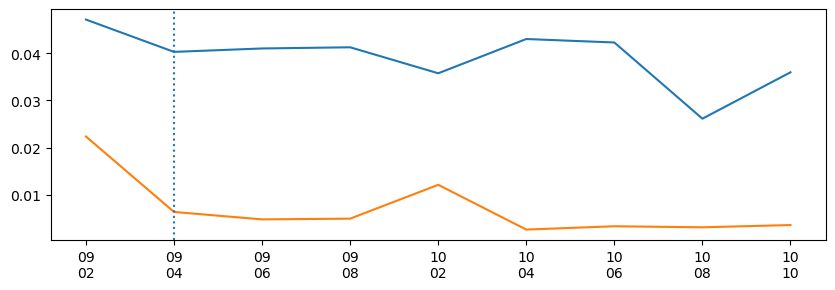

In [42]:
fig,ax = plt.subplots(1,1,figsize = (10,3))

ax.plot(label_sessions,ratio_ripple_sessions,label = "ratio ripples")
ax.plot(label_sessions,ratio_frag_sessions,label = "ratio ripples")
ax.axvline(1,linestyle = ':')
#ax.set_xticks(np.log([0.01,]))
